<a href="https://colab.research.google.com/github/kushal-ks/ML-Training/blob/master/compny_sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import datetime
from datetime import timedelta

import os

In [0]:
train = pd.read_csv('./drive/My Drive/sales/sales_train.csv', parse_dates=['date'])
test = pd.read_csv('./drive/My Drive/sales/test.csv')

In [0]:
def configure_chart():
  plt.figure(figsize=(10, 6))
  plt.xlabel("Time")
  plt.ylabel('Daily Sales')
  plt.grid(True)

In [0]:
def plot_series(time, series, format='-', color='blue', start=0, end=None):
  plt.plot(time[start:end], series[start:end], format, color=color)

In [0]:
def eda_repersentation(df):
    print("----------TOP 5 RECORDS--------")
    print(df.head(5))
    print("----------INFO-----------------")
    print(df.info())
    print("----------Describe-------------")
    print(df.describe())
    print("----------Columns--------------")
    print(df.columns)
    print("----------Data Types-----------")
    print(df.dtypes)
    print("-------Missing Values----------")
    print(df.isnull().sum())
    print("-------NULL values-------------")
    print(df.isna().sum())
    print("-----Shape Of Data-------------")
    print(df.shape)
    

In [8]:
# eda_repersentation(train)
train.fillna(0,inplace = True)
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [9]:
max_date = train['date'].max()
min_date = train['date'].min()
print(max_date)
print(min_date)

2015-12-10 00:00:00
2013-01-01 00:00:00


In [0]:
def group_data(dataframe):
  train_gp = dataframe.reset_index().groupby([ pd.Grouper(key='date', freq = 'D')])[['item_cnt_day']].sum().rename(columns = {'item_cnt_day':'sales'})
  
  return train_gp

# dataset = pd.merge(test,train_gp,on = ['item_id','shop_id'], how = 'left')
# print(train_gp)

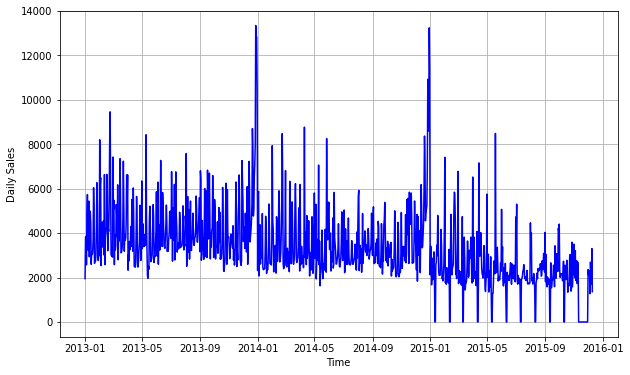

In [11]:
train_gp = group_data(train)
train_gp = train_gp.reset_index()
configure_chart()
plot_series(train_gp['date'], train_gp['sales'])

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = np.array(series)
  series = np.squeeze(series)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [0]:
def train_model(dataset):
  callbacks = myCallback()
  model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(20, input_shape=[30], activation="relu"), 
      tf.keras.layers.Dense(10, activation="relu"),
      tf.keras.layers.Dense(1)
  ])

  model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9), metrics=["mae"])
  history = model.fit(dataset ,epochs=1000,verbose=1, callbacks=[callbacks])

  return model

In [0]:
def forecast_data(new_ts, train_data, model):
  series_new = np.array(ts)
  x_valid = new_ts[split_size:]
  time_stamp = train_data['date']
  forecast = []
  print(time_stamp)
  print(len(new_ts))
  print(len(x_valid))
  print(len(time_stamp[split_size: len(time_stamp)]))
  for time in range(len(x_valid) - window_size):
    forecast.append(model.predict(x_valid[time:time + window_size][np.newaxis]))

  results = np.array(forecast)[:, 0, 0]
  print(len(results))

  configure_chart()

  plot_series(time_stamp[split_size: len(time_stamp) - window_size], x_valid[:len(x_valid) - window_size])
  plot_series(time_stamp[split_size: len(time_stamp) - window_size], results, '-', 'orange')
  new_d = date_range(time_stamp.max(), 30)
  print(type(new_d))
  print(type(time_stamp))
  time_stamp.append(new_d)
  print(time_stamp)
  # next_month_prediction(x_valid, 30, model)

In [0]:
def next_month_prediction(x_valid, window_size, model):
  data_series = x_valid[len(x_valid) - window_size:]
  prediction = np.array(data_series)
  
  for time in range(len(x_valid)):
    data = model.predict(prediction[time:time + window_size][np.newaxis])
    data = np.ravel(data)
    prediction = np.append(prediction, data[0])

  configure_chart()
  time_valid = list(range(0, len(x_valid) + 30))

  data_series = np.append(data_series, prediction[window_size:])
  plot_series(time_valid, data_series)
  plot_series(time_valid[0:len(time_valid) - window_size], data_series[0:len(time_valid) - window_size], '-', 'yellow')

In [0]:
def date_range(start_date, next_days):
  d_list = []
  date_list = [start_date - datetime.timedelta(days=x) for x in range(next_days)]
  date_list = date_list[::-1]
  date_list = pd.to_datetime(date_list)
  date_rng = pd.date_range(start='1/1/2018', end='1/08/2018', freq='D')
  print(type(date_range))
  print(date_range)
  # for d in date_list:
  #   d_list.append(datetime.date(d))
  # print(d_list)D
  # return date_list


In [0]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    DESIRED_ACCURACY = 0.025
    if(logs.get('loss') < DESIRED_ACCURACY):
      print("\nTraining Completed!")
      self.model.stop_training = True

In [0]:
window_size = 30
batch_size = 256
shuffle_buffer_size = 100

In [0]:
train_data = group_data(train)
df=pd.DataFrame(train_data)

df_1=df.values
df_1=df_1.astype('float32')

scaler = MinMaxScaler(feature_range=(-1,1))
ts = scaler.fit_transform(df_1)

In [0]:
ts = np.squeeze(ts)
split_size = 800
x_train = ts[: 800]

In [0]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [37]:
model = train_model(dataset)

Epoch 1/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.1379 - mae: 0.4714
Epoch 2/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.1297 - mae: 0.4544
Epoch 3/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.1147 - mae: 0.4223
Epoch 4/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0984 - mae: 0.3848
Epoch 5/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0836 - mae: 0.3480
Epoch 6/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.0715 - mae: 0.3150
Epoch 7/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0622 - mae: 0.2876
Epoch 8/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.0553 - mae: 0.2648
Epoch 9/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0501 - mae: 0.2468
Epoch 10/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0467 - mae: 0.2333
Epoch 11/1000
4/4 [==============================] - 0s 14m

0      2013-01-01
1      2013-01-02
2      2013-01-03
3      2013-01-04
4      2013-01-05
          ...    
1069   2015-12-06
1070   2015-12-07
1071   2015-12-08
1072   2015-12-09
1073   2015-12-10
Name: date, Length: 1074, dtype: datetime64[ns]
1074
274
274
244
<class 'function'>
<function date_range at 0x7f9aa47486a8>
<class 'NoneType'>
<class 'pandas.core.series.Series'>
0      2013-01-01
1      2013-01-02
2      2013-01-03
3      2013-01-04
4      2013-01-05
          ...    
1069   2015-12-06
1070   2015-12-07
1071   2015-12-08
1072   2015-12-09
1073   2015-12-10
Name: date, Length: 1074, dtype: datetime64[ns]


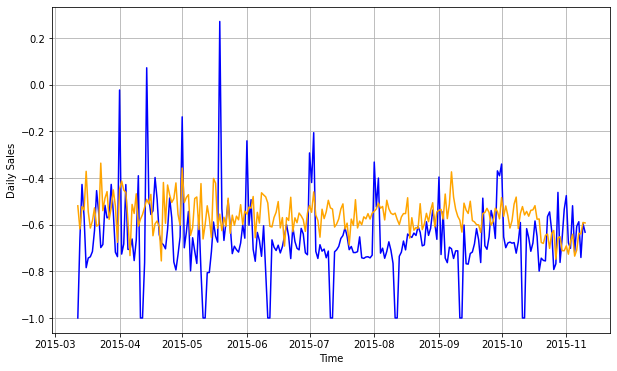

In [114]:
forecast_data(ts, train_gp, model)


In [0]:
for time in range(len(x_valid)):
  data = model.predict(forecast[time:time + window_size][np.newaxis])
  data = np.ravel(data)
  forecast = np.append(forecast, data[0])

configure_chart()
time = [96,97,98,99,100]
series_new = np.append(series_new, forecast[window_size:])
time_valid = np.append(time_valid, time)
plot_series(time_valid, series_new)
plot_series(time_valid[0:len(time_valid) - window_size], series_new[0:len(time_valid) - window_size], '-', choosed_list)


In [39]:
single_shope_data = train.query('shop_id == 5')
shop_train_data = group_data(single_shope_data)
shop_df = pd.DataFrame(shop_train_data)
print(len(shop_df))
df_1 = shop_df.values
df_1=df_1.astype('float32')
scaler = MinMaxScaler(feature_range=(-1,1))
new_ts = scaler.fit_transform(df_1)
x_train = new_ts[:split_size]

1072


In [0]:
new_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [42]:
shop_model = train_model(new_dataset)

Epoch 1/1000
4/4 [==============================] - 0s 20ms/step - loss: 0.2437 - mae: 0.6632
Epoch 2/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.2018 - mae: 0.5974
Epoch 3/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1404 - mae: 0.4875
Epoch 4/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0844 - mae: 0.3637
Epoch 5/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.0484 - mae: 0.2606
Epoch 6/1000
4/4 [==============================] - 0s 20ms/step - loss: 0.0332 - mae: 0.2032
Epoch 7/1000
4/4 [==============================] - 0s 20ms/step - loss: 0.0305 - mae: 0.1854
Epoch 8/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0332 - mae: 0.1907
Epoch 9/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0356 - mae: 0.1981
Epoch 10/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0348 - mae: 0.1956
Epoch 11/1000
4/4 [==============================] - 0s 15m

1072
272
272
242


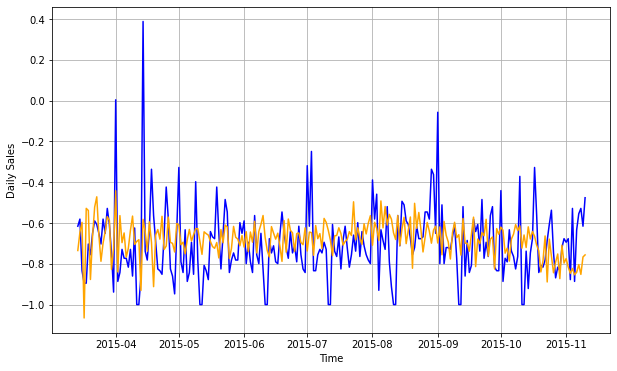

In [43]:
shop_train_data = shop_train_data.reset_index()
new_ts = np.squeeze(new_ts)
forecast_data(new_ts, shop_train_data, shop_model)